# FastText Climate Change Quotes Extraction

# Structure
0. **Introduction** <br>
1. **Things to do before we start** <br>
  1.1 Install libraries <br>
  1.2 Import libraries <br>
  1.3 Mount drive <br>
  1.4 Define global paths <br>
  1.5 Define util functions <br>
2. **Training a model** <br>
  2.1 Preparing quotes for training <br>
  2.2 Merging all chunks <br>
  2.3 Train a model <br>
  2.4 Save the model <br>
  2.5 Load the model <br>
3. **ClimaText dataset comaprison** <br>
  3.1 Extracting features <br>
  3.2 Cosine similarity <br>
  3.3 Precision/recall curve <br>
4. **Extracting quotes** <br>
  4.1 Extracting quotes indexes <br>
  4.2 Save all the indexes <br>
  4.3 Load all the indexes <br>
  4.4 Extract full quotes to json <br>
5. **References**

## 0. Introduction

This notebook is about extracting Climate Change quotes from QuoteBank. Previously, in milestione 2, we extracted quotes that were said by American politicans (democrats or republicans). That (reduced) dataset consisted of more than 5M quotes and was saved in 13 chunks. 

## 1. Things to do before we start

## 1.1 Install libraries

In [ ]:
!pip install fasttext
!pip install nltk

     |████████████████████████████████| 68 kB 6.5 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3123783 sha256=ade4050bbe8711b843806178615c64b4a5539ea23e37d699ba90aa946902ef3d
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


## 1.2 Import libraries

In [ ]:
import fasttext
from fasttext import load_model
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import sys
import codecs
import pickle
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1.3 Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.4 Define global paths

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Merged'
EMBEDDING_PATH = DATA_PATH+'/model_quotes_clean.vec'
PICKLE_PATH  = DATA_PATH + '/climate_change_indexes_new.pickle'
QUOTE_FILES =  ['quotes2015_merged_part_1', 'quotes2015_merged_part_2', 
              'q2', 'quotes2016_merged_part_2',
              'q4', 'q5', 'quotes2017_merged_part_3',
              'q7', 'q8', 'quotes2018_merged_part_3',
              'q10', 'q11', 'quotes2020_merged_part_1']
CHUNKS = len(QUOTE_FILES)
EXTENSION = '.json.bz2'  
EXTRACTED_QUOTES_PATH = DATA_PATH + '/extracetd_quotes.json'

## 1.5 Define util functions

Here we defined functions that we will use in the training and process of quotes extraction given the desired query

In [ ]:
# cache stopword for reuse
cachedStopWords = stopwords.words("english")

def tokenize(text):
    """
    Tokenize an input string so that punctuation and stopwords are removed

    Parameters
    ----------
    text: str
        text on which tokenization should be performed
    Returns
    -------
    str
        String without punctuation and stopwords
    """
    # eliminate punctuations
    text = "".join([ch for ch in text if ch not in string.punctuation])
    # perform word tokenize from nltk to extract words from string
    tokens = nltk.word_tokenize(text)
    # return all words that are not in stopwords
    return " ".join([word.lower() 
                    for word in tokens 
                     if word.lower() not in cachedStopWords])
  
def extract_quotes_indexes(model, query, threshold):
  """
  Extract quote indexes that have similarity with the given query higher than 
  the given threshold

  Parameters
  ----------
  model: object
      fasttext model of word embeddings 
  query: str
      input string query
  threshold: float
      cutoff threshold for cosine similarity  
  Returns
  -------
  array
      return an array of extracted quotes indexes
  """
  # make query vector from query string input 
  query_vector = model.get_sentence_vector(tokenize(query)).reshape(1, -1)
  climate_change_indexes = []
  # iterate through all chunks
  for i in tqdm(range(CHUNKS)):
    indexes = []
    # read a quotes from a file where each line in a file is a quote
    with open(DATA_PATH+"/quotes_"+str(i)+".txt", encoding='utf-8') as f:
        content = f.readlines() 
    # get all original quotes
    original_quotes = [x.strip() for x in content] 

    # iterate through all original quotes
    for i, quote in enumerate(original_quotes):
      # take an embedding of a tokenized quote
      embeddings = model.get_sentence_vector(tokenize(quote)).reshape(1, -1)
      # check if cosine sim is higher than desired threshold
      if threshold < cosine_similarity(embeddings, query_vector)[0][0]:
        indexes.append(i)  
    # append list of indexes with indexes related to chunk
    climate_change_indexes.append(indexes)
  # return a list of indexes
  return climate_change_indexes

## 2. Training a model

### 2.1 Preparing quotes for training

Here, we performed some tricks to prepare our quotes for training. We used function tokenize that we implemented. It works so that it remove puncuations, tokenize word, remove stop-words and lowercase it. 

In [ ]:
# iterate through all chunks
for i in range(CHUNKS):
  # read a quotes from a file where each line in a file is a quote
  with open(DATA_PATH+"/quotes_"+str(i)+".txt", encoding='utf-8') as f:
      content = f.readlines()
  # get all original quotes
  original_quotes = [x.strip() for x in content] 
  # tokenize quotes
  tokenized_quotes = [tokenize(d) for d in original_quotes]
  # make a dataframe and save it to .txt
  df_climate_change = pd.DataFrame(tokenized_quotes, 
                                   columns = ['climate_change'])
  df_climate_change.to_csv(DATA_PATH+"/climate_change_clean_prep"+str(i)+".txt",
                           header=None, index=None, sep='\n')

### 2.2 Merging all chunks

Because of quantity of quotes, we split our dataset by chunks. Now we need to merge all chunks, tokenize quotes and save them.

In [ ]:
frames = []
# iterate through all chunks
for i in range(CHUNKS): 
    # put all frames in a list
    frames.append(pd.read_csv(DATA_PATH+"/climate_change_prep"+str(i)+".txt", 
                              sep='\n', header=None, error_bad_lines=False))
# concatenate all frames into one
df = pd.concat(frames, axis=0)
# export final clean quotes to txt for training
df.to_csv(DATA_PATH+'/climate_change_train.txt', 
          index=False, header=False, sep='\n')

### 2.3 Train a model

After we have saved our merged toknized quotes, now we can perform unsupervised training by FastText.

In [ ]:
# train a model with fasttext unsupervised method and bag of words model
model = fasttext.train_unsupervised(DATA_PATH+'/climate_change_train.txt', 
                                    model = 'cbow') 

### 2.4 Save the model

We will save our model for future reuse, because a process of training is time consuming.

In [ ]:
model.save_model(DATA_PATH+"/fasttext_model.bin")

### 2.5 Load the model

Here, we can load the model that has been previosuly saved.

In [ ]:
model = fasttext.load_model(DATA_PATH+"/fasttext_model.bin")

## 3. ClimaText dataset comaprison 



### 3.1 Extracting features 

We used ClimaText [1] dataset to test performance of our model. We extracted features of interest and took embeddings of quotes.

In [ ]:
# loadding ClimaText test set
test_data = pd.read_csv(DATA_PATH+"/climate_change_test_data.tsv", sep = '\t') 
# setting an index
test_data.set_index('id')
# extracting necessary columns
test_data = test_data[['id', 'label', 'sentence']]
# tokenizing the sentence
test_data['token'] = test_data['sentence'].apply(tokenize)  
# making embedding out of tokens 
test_data['embedding'] = test_data['token'].apply(model.get_sentence_vector) 
# removing nans (if any)
test_data = test_data[~test_data.embedding.isna()] 

### 3.2 Cosine similarity 

We performed cosine similarity with different queries about climate change to see with one gives the best performances with our model and given dataset.

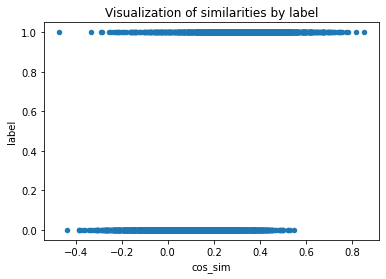

In [ ]:
# defining a query 
climate_change_query = 'climate change' 
# making a query vector embedding 
query_vector = model.get_sentence_vector(climate_change_query).reshape(1, -1)
# helper function for input preparing for cosine similarity function
def sim_with_reshape(x, y): 
  return cosine_similarity(x.reshape(1, -1), y)[0][0] 

# adding similarity column
test_data['cos_sim'] = test_data['embedding'].apply(sim_with_reshape, 
                                                    args=(query_vector,))

# scatter plot of similarities and test labels
test_data.plot.scatter("cos_sim", "label", 
                       title="Visualization of similarities by label")
print()

### 3.3 Precision/recall curve

Here, we plot precision/recall curve specifing precision so that precision and recall stay the same as F1 score.

Threshold: 0.24
Recall: 0.76
F1: 0.77



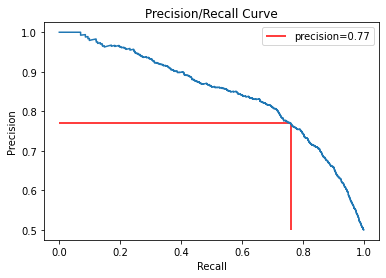

In [ ]:
# ploting precision recall curve and seting desired precision 
# (regarding recall, treshold and F-score) 
# specifying deisred precision
# high quality quotes have high precision, but low recall
PREC = 0.77

# ground truth values
y_true = test_data["label"]
# similarity score values
y_scores = test_data["cos_sim"]
# calculating precsion, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# extracting threshold and recall w.r.t desired precision|
THRESHOLD = round(thresholds[np.searchsorted(precision, PREC)], 2)
RECALL = round(recall[np.searchsorted(precision, PREC)], 2)
# logs treshold and recall
print(f"Threshold: {THRESHOLD}")
print(f"Recall: {RECALL}")

# adding test_label column to dataframe
test_data['test_label'] = (test_data['cos_sim'] > THRESHOLD).astype(int)
# extracting test label for F1 score
y_pred = test_data["test_label"] 
# log F1
F1 = round(f1_score(y_true, y_pred, average='macro'), 2)
print(f"F1: {F1}")

# plot precision/recall curve
plt.plot(recall, precision)
plt.title("Precision/Recall Curve")
plt.hlines(PREC, 0, RECALL, 'r', label="precision="+str(PREC))
plt.vlines(RECALL, 0.5, PREC, 'r')
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
print() 

## 4. Extracting quotes

### 4.1 Extracting quotes indexes

Now, we have quotes but we need to get all other features. Because all indexes stay the same we will extract them first and later load rows from dataframe by our saved indexes.

In [ ]:
# extracting quotes 
climate_change_indexes = extract_quotes_indexes(model, query = "climate change", 
                                                threshold = 0.24)  

### 4.2 Save all the indexes 

In [ ]:
# save indexes with pickle 
PICKLE_PATH  = DATA_PATH + '/climate_change_indexes_new.pickle'
with  open(PICKLE_PATH, "wb") as f:
  pickle.dump(climate_change_indexes, f)

### 4.3 Load all the indexes 

In [ ]:
# Read indexes from file 
file_pickle = open(PICKLE_PATH, 'rb')
climate_change_indexes = pickle.load(file_pickle) 

### 4.4 Extract full quotes to json

Funally, we have indexes of our clamte change related quotes and now we will extract DataFrame containing all of them.

In [ ]:
# initialize vars
quotes_tmp = []
merged_quotes = pd.DataFrame()

In [ ]:
# iterate though all CHUNKS
for i in range(CHUNKS):
  # get extracted indexes
  valid_ind = climate_change_indexes[i]
  # make a quotes path
  quotes_path = DATA_PATH + "/" + QUOTE_FILES[i] + EXTENSION
  # read the quotes from file
  df_quotes= pd.read_json(quotes_path, lines=True, compression = 'bz2')
  # take only valid ones
  quotes_tmp  = df_quotes.iloc[valid_ind] 
  # concatanate with other chunks
  merged_quotes = pd.concat([merged_quotes, quotes_tmp])  
merged_quotes.head(1609)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls
443316,2015-08-17-013108,climate change is different.,Larry Fink,"[Q3218882, Q6490307]",2015-08-17 15:24:19,5,[http://dailykos.com/story/2015/08/17/1412772/...
513425,2015-03-23-062581,Ted Cruz is a climate change denier?,Ted Cruz,[Q2036942],2015-03-23 22:00:00,2,[http://feeds.gawker.com/~r/gizmodo/full/~3/uM...
116079,2015-04-08-000375,a climate change skeptic.,Jeff Sessions,[Q358443],2015-04-08 14:00:00,3,[http://www.usnews.com/opinion/blogs/peter-rof...
904161,2015-12-21-012505,"climate change is more of a threat,",Steve Forbes,"[Q133569, Q19957796, Q7612567, Q780842]",2015-12-21 17:19:45,1,[http://www.bizpacreview.com/2015/12/21/trust-...
53173,2015-04-22-016241,"Hey, Governor Scott! Climate change climate ch...",President Obama,[Q76],2015-04-22 12:17:14,1,[http://feeds.dailykos.com/~r/dailykos/index/~...
...,...,...,...,...,...,...,...
538616,2015-10-01-133073,we're going to have to change our laws.,President Obama,[Q76],2015-10-01 04:19:00,21,[http://www.washingtonpost.com/news/the-fix/wp...
223399,2015-03-19-091132,"This is going to change the landscape,",Bob Buckhorn,[Q4845296],2015-03-19 13:18:53,2,[http://www.mlive.com/news/flint/index.ssf/201...
148446,2015-08-03-006425,are the single biggest source of harmful carbo...,president Barack Obama,[Q76],2015-08-03 05:46:36,1,[http://www.morningstar.co.uk/uk/news/AN_14385...
742955,2015-08-02-053006,the single biggest source of harmful carbon po...,President Obama,[Q76],2015-08-02 07:05:00,1,[http://www.dw.com/en/obama-releases-climate-v...


In [ ]:
# export merged dataframe to json 
merged_quotes.to_json(EXTRACTED_QUOTES_PATH, lines=True, orient='records', compression='bz2')

## 5. References

[1] Varini, Francesco S., et al. “ClimaText: A Dataset for Climate Change Topic Detection.” ArXiv:2012.00483 [Cs], Jan. 2021. arXiv.org, http://arxiv.org/abs/2012.00483.